# Example - Loading and transforming data

In this example we have a lightsheet dataset in OME-Zarr format, along with an atlas (ABAv3) in NIFTI. We have processed the dataset in SPIMquant to obtain NIFTI warps between these, and in this example we show how we can use the warps to transform microscopy data.

In [1]:
#from dask.distributed import Client
#client = Client(processes=False)  # start distributed scheduler locally
#client # this provides link to the Dask dashboard

## ZarrNii class

The `ZarrNii` class represents both OME-Zarr and NIFTI data, and we can load existing datasets using `.from_path()`. Note we can use the same function for both OME-Zarr and NIFTI datasets.

In [2]:
from zarrnii import ZarrNii

znimg = ZarrNii.from_path('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',level=0)
znseg = ZarrNii.from_path('/local/SPIMquant_oznbranch/spimquant/results/tpl-ABAv3/tpl-ABAv3_desc-LR_dseg.nii.gz')
                             

{'scale': [1, 0.004, 0.0018, 0.0018], 'type': 'scale'}
{'scale': [1, 0.004, 0.0018, 0.0018], 'type': 'scale'}


### Taking a look under the hood of a ZarrNii instance

Inspecting the instances, we see that each one contains `vox2ras` and `ras2vox` transformations, as `Transform` objects, along with a `dask.array`, `darr`, which contains the chunked data.


In [3]:
znimg

ZarrNii(darr=dask.array<getitem, shape=(1, 2212, 11732, 7439), dtype=uint16, chunksize=(1, 1, 4096, 4096), chunktype=numpy.ndarray>, ras2vox=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[  -0.        ,   -0.        , -250.        ,   -0.        ],
       [  -0.        , -555.55555556,   -0.        ,   -0.        ],
       [-555.55555556,   -0.        ,   -0.        ,   -0.        ],
       [   0.        ,    0.        ,    0.        ,    1.        ]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None), vox2ras=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[ 0.    ,  0.    , -0.0018,  0.    ],
       [ 0.    , -0.0018,  0.    ,  0.    ],
       [-0.004 ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  1.    ]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None), axes_nifti=False)

In [4]:
znseg

ZarrNii(darr=dask.array<array, shape=(1, 456, 528, 320), dtype=float64, chunksize=(1, 255, 255, 255), chunktype=numpy.ndarray>, ras2vox=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[ 39.9999994 ,   0.        ,   0.        , 227.99998897],
       [  0.        ,  39.9999994 ,   0.        , 312.99998771],
       [  0.        ,   0.        ,  39.9999994 , 113.00000022],
       [  0.        ,   0.        ,   0.        ,   1.        ]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None), vox2ras=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[ 0.025     ,  0.        ,  0.        , -5.69999981],
       [ 0.        ,  0.025     ,  0.        , -7.82499981],
       [ 0.        ,  0.        ,  0.025     , -2.82500005],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None), axes_nifti=True)

The OME-Zarr datasets are ordered by CZYX axes, whereas the NIFTI are ordered by CXYZ. The axis ordering is indicated by the `axes_nifti` attribute. The `vox2ras` for a NIFTI dataset is simply the `affine` you would obtain from `nibabel`. For an OME-Zarr dataset, this `vox2ras` transformation also includes a reordering from ZYX to XYZ, so that the **RAS** space we use is identical for both.

#### Dask arrays

The Dask arrays are nicely visualized by Dask:

In [5]:
znimg.darr

dask.array<getitem, shape=(1, 2212, 11732, 7439), dtype=uint16, chunksize=(1, 1, 4096, 4096), chunktype=numpy.ndarray>

In [6]:
znseg.darr

dask.array<array, shape=(1, 456, 528, 320), dtype=float64, chunksize=(1, 255, 255, 255), chunktype=numpy.ndarray>

Note, you can alter the chunk size when using the `from_path` function:

In [7]:
znimg = ZarrNii.from_path('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',
                                  level=0, chunks=(1,1000,1000,1000), rechunk=True)
znimg.darr


{'scale': [1, 0.004, 0.0018, 0.0018], 'type': 'scale'}
{'scale': [1, 0.004, 0.0018, 0.0018], 'type': 'scale'}


dask.array<rechunk-merge, shape=(1, 2212, 11732, 7439), dtype=uint16, chunksize=(1, 1000, 1000, 1000), chunktype=numpy.ndarray>

## Extracting high-res microscopy subvolumes as NIFTI

In this example, we'll use our atlas segmentation to obtain a bounding box around a label (in this case the dentate gyrus).


In [9]:
#here is an example of cropping using a label, and writing that out as a nifti

#first we obtain the bounding box, knowing that the label 476 is the L Dentate Gyrus granule cell layer
# then use to_nifti() to write to a file.
padding=1
(bbox_min,bbox_max) = znseg.get_bounding_box_around_label(476,ras_coords=True,padding=padding)
(znseg.crop_with_bounding_box(bbox_min,bbox_max,ras_coords=True)
        .to_nifti(f'cropped_seg_pad-{padding}.nii'))


[[ 94]
 [164]
 [ 69]]
<class 'numpy.ndarray'>
(3, 1)
[[ 94.]
 [164.]
 [ 69.]]
<class 'numpy.ndarray'>
(3, 1)
[[ 93]
 [163]
 [ 68]]
<class 'numpy.ndarray'>
(3, 1)
[[ 93.]
 [163.]
 [ 68.]]
<class 'numpy.ndarray'>
(3, 1)
[[ 92]
 [162]
 [ 67]]
<class 'numpy.ndarray'>
(3, 1)
[[ 92.]
 [162.]
 [ 67.]]
<class 'numpy.ndarray'>
(3, 1)
[[ 89]
 [159]
 [ 64]]
<class 'numpy.ndarray'>
(3, 1)
[[ 89.]
 [159.]
 [ 64.]]
<class 'numpy.ndarray'>
(3, 1)
[[ 84]
 [154]
 [ 59]]
<class 'numpy.ndarray'>
(3, 1)
[[ 84.]
 [154.]
 [ 59.]]
<class 'numpy.ndarray'>
(3, 1)


In [18]:
# if we want e.g. to crop the same structure in the subject microscopy image, 
# we can either transform the image and use a cropped ref, or, we can transform the bounding box corners

array([[ 93.],
       [163.],
       [ 68.]])

In [19]:
# to do the latter, we can use:
znseg.apply_transform_flo_to_ref_indices(ref_dimg=znimg, 

array([[223.],
       [283.],
       [232.]])

In [11]:
#now crop the ref image:
cropped_seg = znseg.crop_with_bounding_box(bbox_min,bbox_max,ras_coords=True)
cropped_seg.darr

dask.array<getitem, shape=(1, 128, 118, 162), dtype=float64, chunksize=(1, 128, 91, 162), chunktype=numpy.ndarray>

dask.array<array, shape=(1, 456, 528, 320), dtype=float64, chunksize=(1, 255, 255, 255), chunktype=numpy.ndarray>

**MOVE THIS TO ANOTHER SECTION** This runs very fast, because it is not actually doing the computation yet. Any operation you perform on Dask arrays is **lazy**, meaning that it does not compute until you explicitly tell it to, with `compute()`. At that point it then runs everything, parallelizing where possible.

In [13]:
ref_cropped = znseg.crop_with_bounding_box(min_extent, max_extent)

Note now in the output the size has changed, along with the transforms.  Again, we haven't done any computing yet since crop is also **lazy**. 

In [14]:
ref_cropped

ZarrNii(darr=dask.array<getitem, shape=(1, 128, 118, 162), dtype=float64, chunksize=(1, 128, 91, 162), chunktype=numpy.ndarray>, ras2vox=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[ 39.9999994 ,   0.        ,   0.        , 133.99998897],
       [  0.        ,  39.9999994 ,   0.        , 148.99998771],
       [  0.        ,   0.        ,  39.9999994 ,  44.00000022],
       [  0.        ,   0.        ,   0.        ,   1.        ]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None), vox2ras=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[ 0.025     ,  0.        ,  0.        , -3.34999977],
       [ 0.        ,  0.025     ,  0.        , -3.72499975],
       [ 0.        ,  0.        ,  0.025     , -1.10000002],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None), axes_nifti=True)

In [15]:
ref_cropped.darr

dask.array<getitem, shape=(1, 128, 118, 162), dtype=float64, chunksize=(1, 128, 91, 162), chunktype=numpy.ndarray>

In [16]:
#now let's crop a slice from the middle

In [17]:
ref_slice = ref_cropped.crop_with_bounding_box([0,0,80],[128,118,81])
ref_slice.darr

dask.array<getitem, shape=(1, 128, 118, 1), dtype=float64, chunksize=(1, 128, 91, 1), chunktype=numpy.ndarray>

In [18]:
from zarrnii import Transform

#let's reload the lightsheet data but from a downsampled level
flo_znimg = ZarrNii.from_path('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',
                                  level=4)
resampled = flo_znimg.apply_transform(
    Transform.affine_ras_from_txt('/local/SPIMquant_oznbranch/spimquant/results/sub-o28/warps/sub-o28_sample-brain_acq-prestitched_from-subject_to-ABAv3_type-ras_desc-affine_xfm.txt'),
    ref_dimg=ref_slice)

resampled.darr

dask.array<interp_by_block, shape=(1, 128, 118, 1), dtype=float32, chunksize=(1, 128, 91, 1), chunktype=numpy.ndarray>

In [19]:
resampled.to_nifti('dg_downsampled.nii')

/local/scratch/pypoetry_venv/zarrnii-bN9WqXf7-py3.9/lib/python3.9/site-packages/distributed/client.py:3166: UserWarning: Sending large graph of size 253.14 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


### Zoomed reference
If we want higher-res, we can use a reference with a zoomed in FOV. We don't want to actually resample the reference image, just the shape of it, so we make use of an alternative to `from_path()`, which is `from_path_as_ref()`, which uses an empty array instead of the actual data. 

In [20]:
ref_zoomed = ZarrNii.from_path_as_ref('/local/SPIMquant_oznbranch/spimquant/results/tpl-ABAv3/tpl-ABAv3_desc-LR_dseg.nii.gz',
                                      zooms=(0.005,0.005,0.005))
            


## Example simply writing downsampled NIFTI from OME-Zarr

In [1]:
from zarrnii import ZarrNii

In [2]:
#test out writing to nifti downsampled
znimg_ds5 = (ZarrNii.from_path('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',
                                 level=5,channels=[0])
                .downsample_by_local_mean(ds_z=2**3) #same downsample rate as X and Y
                .to_nifti('sub-o28_stain-PI_ds-5_SPIM_origaffine.nii'))


In [2]:
znimg_ds5 = (ZarrNii.from_path('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',
                                 level=5,channels=[0])
                .downsample_by_local_mean(ds_z=2**3)
                .crop_with_bounding_box((4,6,1),(30,50,25))) #same downsample rate as X and Y
znimg_ds5.vox2ras.affine


array([[ 0.    ,  0.    , -0.0576, -0.0576],
       [ 0.    , -0.0576,  0.    , -0.3456],
       [-0.032 ,  0.    ,  0.    , -0.128 ],
       [ 0.    ,  0.    ,  0.    ,  1.    ]])

In [10]:
znimg_ds5.to_ome_zarr('test_crop.ome.zarr')

[########################################] | 100% Completed | 540.31 ms


In [3]:
import nibabel as nib

nii_nib = nib.load('sub-o28_stain-PI_ds-5_SPIM.nii')
nii_nib_compare = nib.load('/local/SPIMquant_oznbranch/spimquant/results/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_stain-PI_level-5_SPIM.nii')
nii_nib_compare_orig = nib.load('sub-o28_stain-PI_ds-5_SPIM_origaffine.nii')


In [4]:
print(nii_nib.affine)
print(nii_nib.get_fdata().shape)

[[-0.0576  0.      0.     -0.    ]
 [ 0.     -0.0576  0.     -0.    ]
 [ 0.      0.     -0.032  -0.    ]
 [ 0.      0.      0.      1.    ]]
(232, 366, 276)


In [5]:
print(nii_nib_compare.affine)
print(nii_nib_compare.get_fdata().shape)

[[-0.0576  0.      0.      0.    ]
 [ 0.     -0.0576  0.      0.    ]
 [ 0.      0.     -0.032   0.    ]
 [ 0.      0.      0.      1.    ]]
(232, 366, 277)


In [6]:
print(nii_nib_compare_orig.affine)
print(nii_nib_compare_orig.get_fdata().shape)

[[ 0.      0.     -0.0576  0.    ]
 [ 0.     -0.0576  0.      0.    ]
 [-0.032   0.      0.      0.    ]
 [ 0.      0.      0.      1.    ]]
(276, 366, 232)


In [3]:
znimg_ds5.darr

dask.array<getitem, shape=(1, 2212, 366, 232), dtype=uint16, chunksize=(1, 1, 366, 232), chunktype=numpy.ndarray>

In [4]:
znimg_ds5.downsample_by_local_mean_z(downsampling=100).darr

dask.array<lambda, shape=(1, 23, 366, 232), dtype=uint16, chunksize=(1, 1, 366, 232), chunktype=numpy.ndarray>

In [7]:
znimg_ds5.downsample_by_local_mean(ds_x=1,ds_y=1,ds_z=4).darr

dask.array<coarsen, shape=(1, 553, 366, 232), dtype=float64, chunksize=(1, 1, 366, 232), chunktype=numpy.ndarray>

In [7]:
import numpy as np

In [38]:
zarr_scaling = np.diag([4,1,1,1])
zarr_translation = (5,10,15)
zarr_scaling[:3,3] = zarr_translation
zarr_scaling

array([[ 4,  0,  0,  5],
       [ 0,  1,  0, 10],
       [ 0,  0,  1, 15],
       [ 0,  0,  0,  1]])

In [39]:
reorder_xfm = np.eye(4)
reorder_xfm[:3, :3] = np.flip(
    reorder_xfm[:3, :3], axis=0
)  # reorders z-y-x to x-y-z and vice versa
reorder_xfm

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [42]:
reorder_xfm @ zarr_scaling

array([[ 0.,  0.,  1., 15.],
       [ 0.,  1.,  0., 10.],
       [ 4.,  0.,  0.,  5.],
       [ 0.,  0.,  0.,  1.]])

In [43]:
flip_xfm = np.diag((-1,-1,-1,1))
flip_xfm
                   

array([[-1,  0,  0,  0],
       [ 0, -1,  0,  0],
       [ 0,  0, -1,  0],
       [ 0,  0,  0,  1]])

In [44]:
affine = flip_xfm @ reorder_xfm @ zarr_scaling
affine

array([[  0.,   0.,  -1., -15.],
       [  0.,  -1.,   0., -10.],
       [ -4.,   0.,   0.,  -5.],
       [  0.,   0.,   0.,   1.]])

In [18]:
# to obtain scaling for writing back to zarr
flip_xfm @ reorder_xfm @affine

array([[4., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [6]:
#znseg has our atlas
# pull out a bounda

#now crop based on bounding box

#bbox_min=(54,132,81)
#bbox_max=(140,240,262)

bbox_min=(54,132,120)
bbox_max=(140,240,140)

ref_cropped = template_anat.crop_with_bounding_box(bbox_min,bbox_max)
ref_cropped.darr = ref_cropped.darr.rechunk((1,50,50,1))


ref_zoomed = ZarrNii.from_path_as_ref('/local/SPIMquant_oznbranch/spimquant/results/tpl-ABAv3/tpl-ABAv3_anat.nii.gz',zooms=(0.008,0.008,0.008),chunks=(600,600,1))

znimg_zoomed = ZarrNii.from_path('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',level=5,chunks=(50,50,50))

ref_zoomed
#ref_zoomed.darr
#ref_slice = znimg_zoomed.darr[:,1000,:,:].compute()

NameError: name 'template_anat' is not defined

In [13]:
znimg.vox2ras

Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[ 0.    ,  0.    , -0.0072,  0.    ],
       [ 0.    , -0.0072,  0.    ,  0.    ],
       [-0.004 ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  1.    ]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None)

In [14]:
ref_zoomed.vox2ras

Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[ 0.008     ,  0.        ,  0.        , -5.69999981],
       [ 0.        ,  0.008     ,  0.        , -7.82499981],
       [ 0.        ,  0.        ,  0.008     , -2.82500005],
       [ 0.        ,  0.        ,  0.        ,  1.        ]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None)

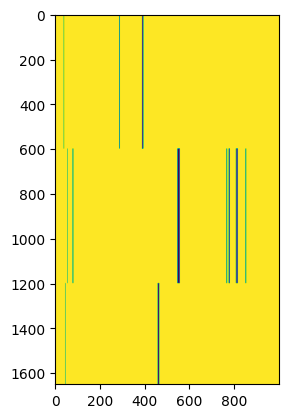

In [9]:
import matplotlib.pyplot as plt
plt.imshow(ref_zoomed.darr[:,100,:,:].squeeze())

In [27]:
subj_warped = znimg.apply_transform(
                    Transform.affine_ras_from_txt('/local/SPIMquant_oznbranch/spimquant/results/sub-o28/warps/sub-o28_sample-brain_acq-prestitched_from-subject_to-ABAv3_type-ras_desc-affine_xfm.txt'),
                    ref_dimg=ref_zoomed)
#import numpy as np
#subj_warped = znimg.apply_transform(
#                    Transform.affine_ras_from_array(np.eye(4)),
#                    ref_dimg=znimg_zoomed)



In [28]:
subj_warped.darr

dask.array<interp_by_block, shape=(1, 1425, 1650, 1000), dtype=float32, chunksize=(1, 600, 600, 1), chunktype=numpy.ndarray>

In [32]:
warped_subvol = subj_warped.darr[:,:,:,500].compute()

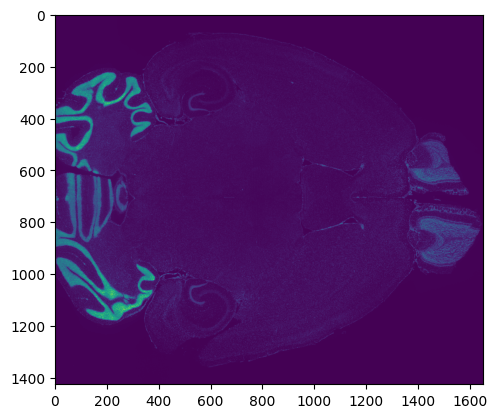

In [33]:

plt.imshow(warped_subvol[:,:,:].squeeze())

In [6]:
#performing compute on a slice of the darr works, 
#now let's try using our new crop function to compute on a slice

#crop the reference image
print(ref_zoomed.vox2ras.affine)
      
ref_cropped = ref_zoomed.crop_with_bounding_box((0,0,500),(1425,1650,501))
print(ref_cropped.vox2ras.affine)

[[ 0.008       0.          0.         -5.69999981]
 [ 0.          0.008       0.         -7.82499981]
 [ 0.          0.          0.008      -2.82500005]
 [ 0.          0.          0.          1.        ]]
translation ras space
[[ 1.          0.          0.          5.69999981]
 [ 0.          1.          0.          7.82499981]
 [ 0.          0.          1.         -1.17499995]
 [ 0.          0.          0.          1.        ]]
[[ 0.008       0.          0.         -5.69999981]
 [ 0.          0.008       0.         -7.82499981]
 [ 0.          0.          0.008       1.17499995]
 [ 0.          0.          0.          1.        ]]


In [32]:
subj_warped = znimg.apply_transform(
                    Transform.affine_ras_from_txt('/local/SPIMquant_oznbranch/spimquant/results/sub-o28/warps/sub-o28_sample-brain_acq-prestitched_from-subject_to-ABAv3_type-ras_desc-affine_xfm.txt'),
                    ref_dimg=ref_cropped)

warped_cropvol = subj_warped.darr.compute()

In [33]:
ref_cropped

ZarrNii(darr=dask.array<interp_by_block, shape=(1, 600, 800, 1), dtype=float32, chunksize=(1, 400, 400, 1), chunktype=numpy.ndarray>, ras2vox=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[ 2.50000000e+02,  0.00000000e+00,  0.00000000e+00,
        -5.75000048e+02],
       [ 0.00000000e+00,  2.50000000e+02,  0.00000000e+00,
         1.15624995e+03],
       [ 0.00000000e+00,  0.00000000e+00,  2.50000000e+02,
        -2.93749988e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None), vox2ras=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[ 4.00000000e-03,  0.00000000e+00,  0.00000000e+00,
         2.30000019e+00],
       [ 0.00000000e+00,  4.00000000e-03,  0.00000000e+00,
        -4.62499981e+00],
       [ 0.00000000e+00,  0.00000000e+00,  4.00000000e-03,
         1.17499995e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), d

In [34]:
ref_zoomed

ZarrNii(darr=dask.array<empty_like, shape=(1, 2850, 3300, 2000), dtype=float64, chunksize=(1, 600, 600, 1), chunktype=numpy.ndarray>, ras2vox=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[2.50000000e+02, 0.00000000e+00, 0.00000000e+00, 1.42499995e+03],
       [0.00000000e+00, 2.50000000e+02, 0.00000000e+00, 1.95624995e+03],
       [0.00000000e+00, 0.00000000e+00, 2.50000000e+02, 7.06250012e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None), vox2ras=Transform(tfm_type=<TransformType.AFFINE_RAS: 1>, affine=array([[ 4.00000000e-03,  0.00000000e+00,  0.00000000e+00,
        -5.69999981e+00],
       [ 0.00000000e+00,  4.00000000e-03,  0.00000000e+00,
        -7.82499981e+00],
       [ 0.00000000e+00,  0.00000000e+00,  4.00000000e-03,
        -2.82500005e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), disp_xyz=None, disp_grid=None, disp_ras2vox=None)

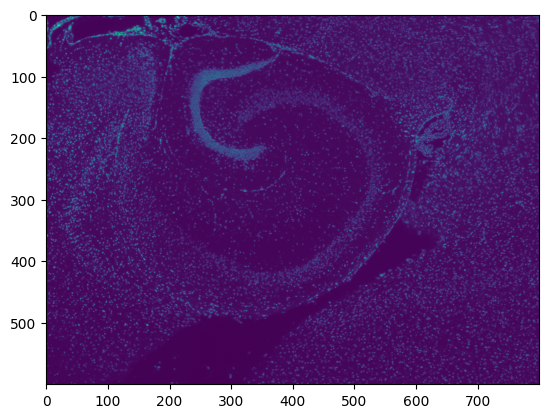

In [35]:
import matplotlib.pyplot as plt
plt.imshow(warped_cropvol[:,:,:].squeeze())

In [3]:
ref_znimg = ZarrNii.from_path_as_ref('/local/SPIMquant_oznbranch/spimquant/results/tpl-ABAv3/tpl-ABAv3_anat.nii.gz',zooms=(1,1,1))
ref_znimg.darr

dask.array<empty_like, shape=(1, 11, 13, 8), dtype=float64, chunksize=(1, 11, 13, 8), chunktype=numpy.ndarray>

In [4]:
subj_warped = znimg.apply_transform(
                    Transform.affine_ras_from_txt('/local/SPIMquant_oznbranch/spimquant/results/sub-o28/warps/sub-o28_sample-brain_acq-prestitched_from-subject_to-ABAv3_type-ras_desc-affine_xfm.txt'),
                    ref_dimg=ref_znimg)



In [ ]:
with ProgressBar():
    vol = subj_warped.darr.compute(scheduler='single-threaded')

[                                        ] | 0% Completed | 34.74 sms

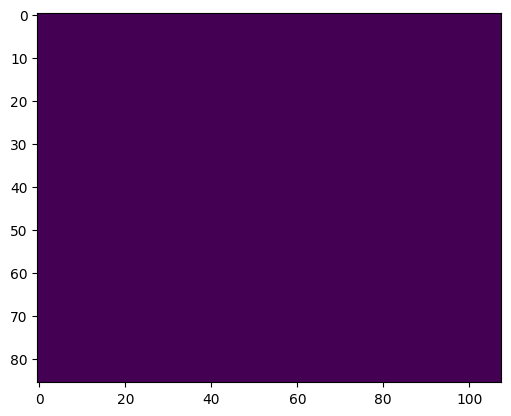

In [6]:
import matplotlib.pyplot as plt
plt.imshow(vol[0,:,:,50])

In [9]:
vol.min()

0.0

In [7]:
vol.max()

0.0

# try with identity below, ref same as float

In [5]:
import numpy as np

znimg_flo = ZarrNii.from_path('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',level=3)
znimg_ref = ZarrNii.from_path_as_ref('/cifs/prado/Kate/AK_Pipeline_LSM/spimprep/bids/sub-o28/micr/sub-o28_sample-brain_acq-prestitched_SPIM.ome.zarr',level=4)

znimg_warped = znimg_flo.apply_transform(Transform.affine_ras_from_array(np.eye(4)),ref_dimg=znimg_ref)

In [6]:
znimg_warped.darr

dask.array<interp_by_block, shape=(1, 2212, 733, 464), dtype=float32, chunksize=(1, 50, 50, 50), chunktype=numpy.ndarray>

In [31]:
# test translation/crop
from zarrnii import ZarrNii, Transform

ref_zoomed = ZarrNii.from_path_as_ref('/local/SPIMquant_oznbranch/spimquant/results/tpl-ABAv3/tpl-ABAv3_anat.nii.gz',zooms=(0.004,0.004,0.004),chunks=(600,600,1))

#crop the reference image
print(ref_zoomed.vox2ras.affine)
      
ref_cropped = ref_zoomed.crop_with_bounding_box((2000,800,1000),(2600,1600,1001))
print(ref_cropped.vox2ras.affine)

[[ 4.00000000e-03  0.00000000e+00  0.00000000e+00 -5.69999981e+00]
 [ 0.00000000e+00  4.00000000e-03  0.00000000e+00 -7.82499981e+00]
 [ 0.00000000e+00  0.00000000e+00  4.00000000e-03 -2.82500005e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
translation ras space
[[ 1.          0.          0.         -2.30000019]
 [ 0.          1.          0.          4.62499981]
 [ 0.          0.          1.         -1.17499995]
 [ 0.          0.          0.          1.        ]]
[[ 4.00000000e-03  0.00000000e+00  0.00000000e+00  2.30000019e+00]
 [ 0.00000000e+00  4.00000000e-03  0.00000000e+00 -4.62499981e+00]
 [ 0.00000000e+00  0.00000000e+00  4.00000000e-03  1.17499995e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [24]:
ref_zoomed.darr

dask.array<empty_like, shape=(1, 2850, 3300, 2000), dtype=float64, chunksize=(1, 600, 600, 1), chunktype=numpy.ndarray>

In [25]:
ref_cropped.darr

dask.array<getitem, shape=(1, 600, 800, 1), dtype=float64, chunksize=(1, 400, 400, 1), chunktype=numpy.ndarray>